In [2]:
!conda -V

conda 23.5.2


In [7]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
#from catboost import CatBoostRegressor

In [8]:
path='/home/yik.zhang/Desktop/Predict_CO2_Emissions_in_Rwanda'

# data processing and visualization 

In [9]:
train = pd.read_csv(path+'/dataset/train.csv')
test = pd.read_csv(path+'/dataset/test.csv')
submission = pd.read_csv(path+'/dataset/sample_submission.csv')

In [11]:
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,35.874496,-0.000027,0.035370,1589.024536,4061.098145,829530.500000,71.111977,52.775928,-149.875565,25.965214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000117,0.863230,0.000038,0.255668,35.874496,-130.050797,50.843559,-98.593887,-1.280761,829864.546875,-12.628979,35.632416,-138.786446,30.752128,0.115927,2.506609,0.295663,225.731144,0.595473,-12.628979,35.632416,-138.786446,30.752128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.595473,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,-140.874435,28.965133,0.000012,0.036526,1772.574405,1869.040414,829787.287130,-1.019594,38.982368,-140.158048,29.562000,0.000047,1.639765e-05,0.00003,0.000093,7311.869141,-1.935386,0.067038,829859.960368,5.471037,35.265195,-138.343908,30.054262,0.000170,1.172826,0.000143,0.200754,29.071781,-141.814827,43.050213,4.678839,-1.548119,829747.856973,16.152492,43.485327,-142.786141,28.573627,0.116775,2.657704,0.315733,226.172170,0.175166,24.464335,42.596541,-143.097868,28.213655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.213608,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.

In [9]:
# check nan ratio
100*train.isna().sum().sort_values(ascending = False) / train.shape[0]

UvAerosolLayerHeight_aerosol_height          99.444466
UvAerosolLayerHeight_solar_zenith_angle      99.444466
UvAerosolLayerHeight_solar_azimuth_angle     99.444466
UvAerosolLayerHeight_sensor_azimuth_angle    99.444466
UvAerosolLayerHeight_aerosol_pressure        99.444466
                                               ...    
latitude                                      0.000000
week_no                                       0.000000
year                                          0.000000
longitude                                     0.000000
emission                                      0.000000
Length: 76, dtype: float64

Text(0.5, 1.0, 'Distribution of Emission')

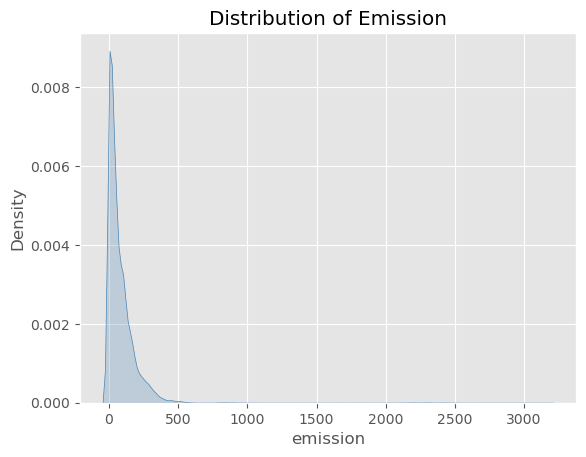

In [10]:
# visualize the distribution -- call sns kdeplot for showing pdf of the target variable
sns.kdeplot(data = train, x = 'emission', fill = True, color = 'steelblue').set_title('Distribution of Emission')
# see if the distribution changes along time

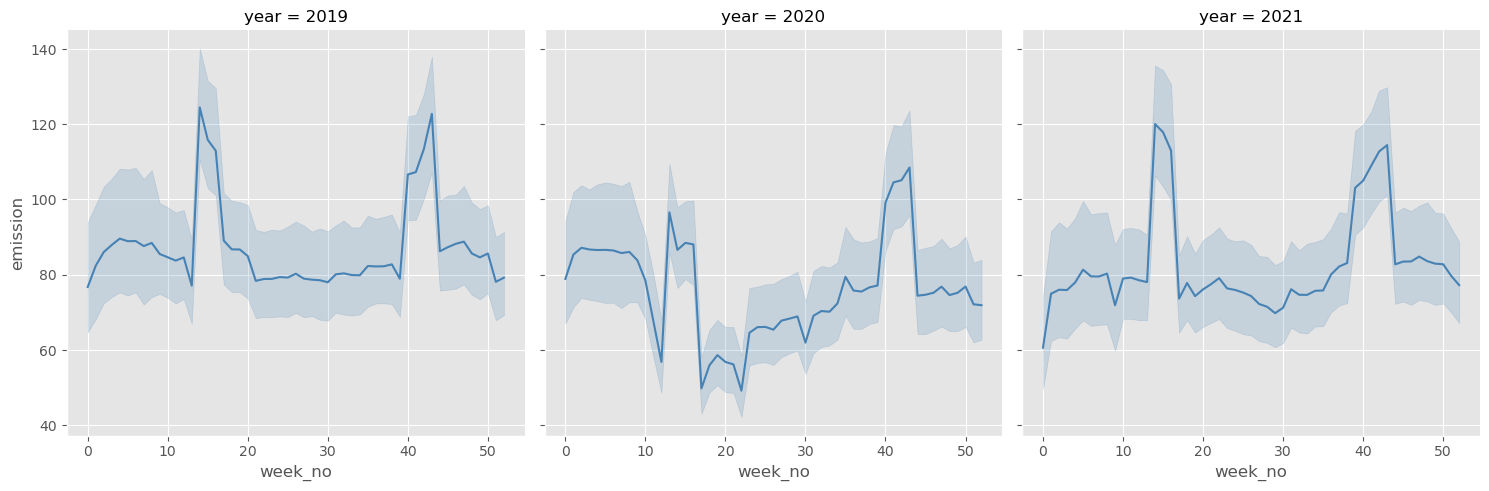

In [12]:
# visualize the time series of the output
sns.relplot(data = train, x = 'week_no', y = 'emission', col = 'year', kind = 'line', color = 'steelblue');

In [14]:
# visualize the emission at locations
fig = px.scatter_mapbox(train[train['year'] == 2019], 
                        lat = 'latitude', 
                        lon = 'longitude', 
                        color = 'emission',
                        animation_frame = 'week_no',
                        zoom = 6)

fig.update_layout(mapbox_style = "open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show();

# Baseline model 1 -- lightboost only call time realted features -- no other varibales

In [4]:


# create new features -- simple new feature

train['covid_flag'] = np.where((train['year'] == 2020) & (train['week_no'] >= 11) & (train['week_no'] <= 40), 1, 0)
test['covid_flag'] = 0

train['week_no_sin'] = np.sin(train['week_no']*(2*np.pi/52))
train['week_no_cos'] = np.cos(train['week_no']*(2*np.pi/52))

test['week_no_sin'] = np.sin(test['week_no']*(2*np.pi/52))
test['week_no_cos'] = np.cos(test['week_no']*(2*np.pi/52))


# create a new category as location
train['location'] = [str(train['latitude'][i]) + '_' + str(train['longitude'][i]) for i in range(0, train.shape[0])]
test['location'] = [str(test['latitude'][i]) + '_' + str(test['longitude'][i]) for i in range(0, test.shape[0])]

train['location'] = train['location'].astype('category')
test['location'] = test['location'].astype('category')


In [18]:
X = train[['year', 'week_no', 'location', 'covid_flag', 'week_no_sin', 'week_no_cos']].copy()
Y = train['emission']

test_baseline = test[['week_no', 'location', 'covid_flag', 'week_no_sin', 'week_no_cos']].copy()

lgb_cv_scores, lgb_preds, lgb_imp = list(), list(), list()

kf = GroupKFold(n_splits = 3)

for i, (trn_idx, test_idx) in enumerate(kf.split(X, groups = X.year)):
    
    X_train, X_valid = X.iloc[trn_idx], X.iloc[test_idx]
    Y_train, Y_valid = Y.iloc[trn_idx], Y.iloc[test_idx]
    
    X_train = X_train.drop(columns = 'year', axis = 1)
    X_valid = X_valid.drop(columns = 'year', axis = 1)
        
    print('---------------------------------------------------------------')
            
    ##############
    ## LightGBM ##
    ##############
    
    lgb_md = LGBMRegressor(n_estimators = 1000,
                           max_depth = 15,
                           learning_rate = 0.01,
                           num_leaves = 105,
                           reg_alpha = 0.1,
                           reg_lambda = 0.1,
                           subsample = 0.7,
                           colsample_bytree = 0.8).fit(X_train, Y_train)
    
    lgb_pred_1 = lgb_md.predict(X_valid)
    lgb_pred_2 = lgb_md.predict(test_baseline)
    lgb_score_fold = mean_squared_error(Y_valid, lgb_pred_1, squared = False)
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)
    lgb_imp.append(lgb_md.feature_importances_)
    
    print('Fold', i, '==> LGBM oof RMSE is ==>', lgb_score_fold)


---------------------------------------------------------------
Fold 0 ==> LGBM oof RMSE is ==> 16.771641932373477
---------------------------------------------------------------
Fold 1 ==> LGBM oof RMSE is ==> 27.85741025897529
---------------------------------------------------------------
Fold 2 ==> LGBM oof RMSE is ==> 17.164752140566275


In [20]:
trn_idx.shape

(52682,)

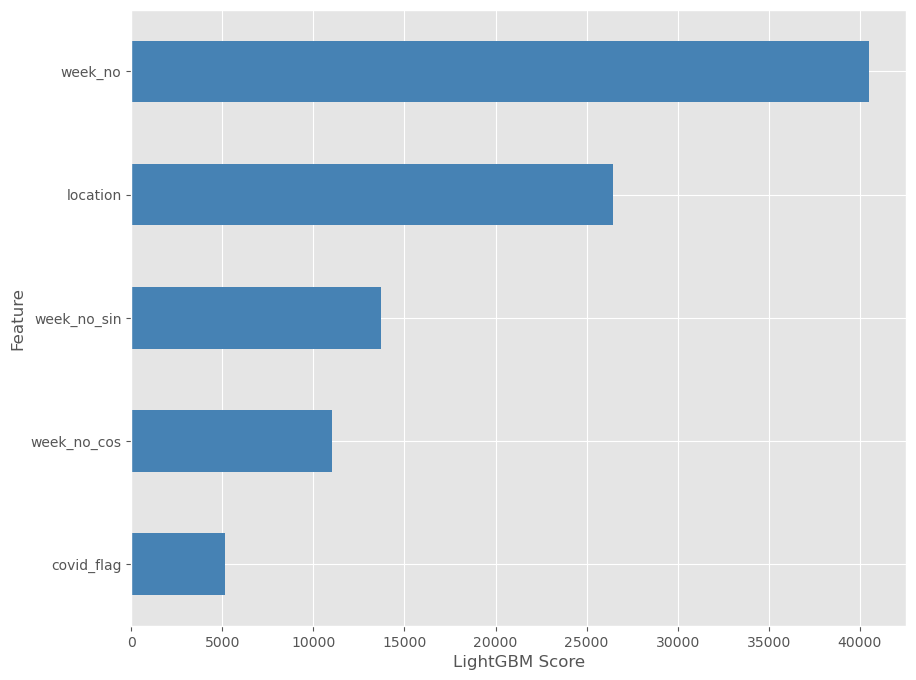

In [23]:
# create the feature importance

plt.figure(figsize = (10, 8))
pd.DataFrame(lgb_imp, columns = X.columns[1:]).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh', color = 'steelblue');
plt.xlabel('LightGBM Score')
plt.ylabel('Feature')
plt.show();

In [25]:
# prediction

preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)
submission['emission'] = preds_test
submission.head()

submission.to_csv('LightGBM_Baseline_submission_01.csv', index = False)

# Baseline 2 -- Create model w/o outliers

<Figure size 1800x800 with 0 Axes>

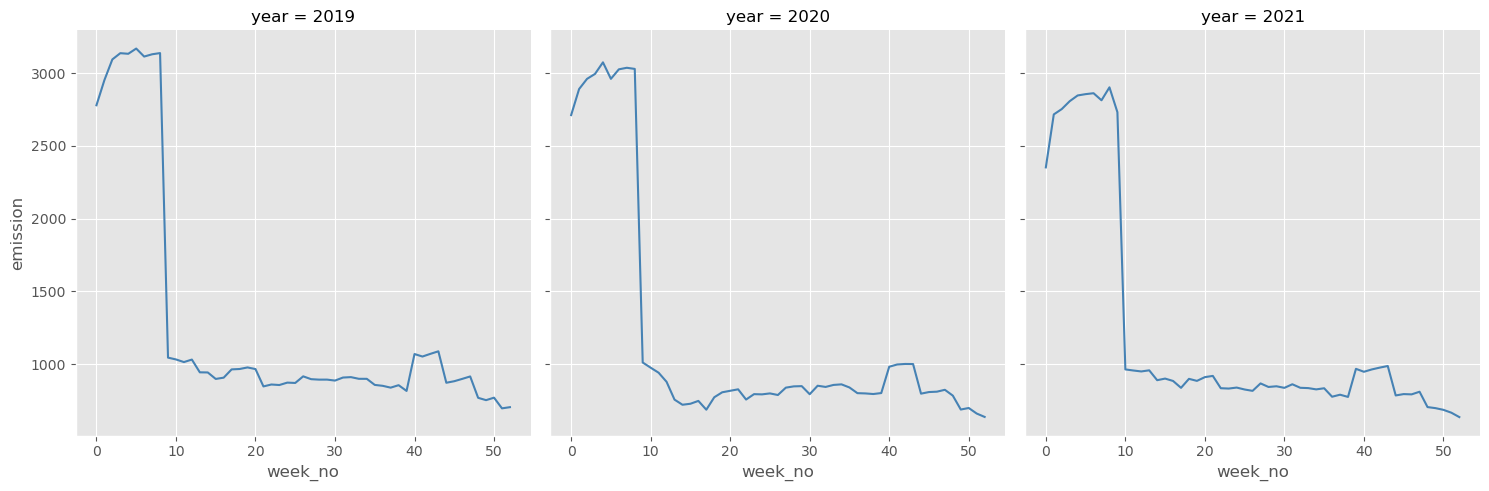

In [26]:


plt.figure(figsize = (18, 8))

sns.relplot(data = train[train['location'] == '-2.079_29.321'], x = 'week_no', y = 'emission', col = 'year', kind = 'line', color = 'steelblue');


In [16]:
test

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,covid_flag,week_no_sin,week_no_cos,location
0,ID_-0.510_29.290_2022_00,-0.510,29.290,2022,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.561522,829937.000000,-100.113785,33.696957,-133.047562,33.779572,0.112175,2.374888,0.269846,227.193100,0.485340,-100.113785,33.696957,-133.047562,33.779572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.485129,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583,0,0.000000,1.000000,-0.51_29.29
1,ID_-0.510_29.290_2022_01,-0.510,29.290,2022,1,0.000456,0.691164,0.000316,0.000000,76.239196,15.600607,-140.529848,28.896124,0.000157,0.037641,1688.656342,2814.309683,829652.957598,26.072167,25.189549,-142.612636,28.318923,0.000048,1.117653e-05,0.000037,0.000093,7311.869141,-1.416309,0.036769,829736.125000,76.239196,15.600607,-140.529848,28.896124,0.000123,0.957096,0.000058,0.000000,28.896124,-140.529848,15.600607,76.239196,-0.823662,829753.051343,-0.009998,34.745542,-139.171039,30.405075,0.112643,2.537305,0.290184,228.489219,0.515679,-0.009998,34.745542,-139.171039,30.405075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.711262,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380,0,0.120537,0.992709,-0.51_29.29
2,ID_-0.510_29.290_2022_02,-0.510,29.290,2022,2,0.000161,0.605107,0.000106,0.079870,-42.055341,39.889060,-136.908976,30.054682,0.000053,0.037795,2629.69

In [12]:
test[~np.isin(test['location'], outliers)].copy()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,covid_flag,week_no_sin,week_no_cos,location
0,ID_-0.510_29.290_2022_00,-0.510,29.290,2022,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.561522,829937.000000,-100.113785,33.696957,-133.047562,33.779572,0.112175,2.374888,0.269846,227.193100,0.485340,-100.113785,33.696957,-133.047562,33.779572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.485129,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583,0,0.000000,1.000000,-0.51_29.29
1,ID_-0.510_29.290_2022_01,-0.510,29.290,2022,1,0.000456,0.691164,0.000316,0.000000,76.239196,15.600607,-140.529848,28.896124,0.000157,0.037641,1688.656342,2814.309683,829652.957598,26.072167,25.189549,-142.612636,28.318923,0.000048,1.117653e-05,0.000037,0.000093,7311.869141,-1.416309,0.036769,829736.125000,76.239196,15.600607,-140.529848,28.896124,0.000123,0.957096,0.000058,0.000000,28.896124,-140.529848,15.600607,76.239196,-0.823662,829753.051343,-0.009998,34.745542,-139.171039,30.405075,0.112643,2.537305,0.290184,228.489219,0.515679,-0.009998,34.745542,-139.171039,30.405075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.711262,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380,0,0.120537,0.992709,-0.51_29.29
2,ID_-0.510_29.290_2022_02,-0.510,29.290,2022,2,0.000161,0.605107,0.000106,0.079870,-42.055341,39.889060,-136.908976,30.054682,0.000053,0.037795,2629.69

### The second outlier is the location with latitude = -2.378 and longitute = 29.222

In [5]:
# first train a lightboost on non-outlier dataset 

outliers = ['-2.079_29.321', '-2.378_29.222']

# remove the outlier grid point only
train_no_outlier = train[~np.isin(train['location'], outliers)].copy()
test_no_outlier = test[~np.isin(test['location'], outliers)].copy() # num of non-outlier points in test dataset: 24353 - 24255

X = train_no_outlier[['year', 'week_no', 'location', 'covid_flag', 'week_no_sin', 'week_no_cos']].copy()
Y = train_no_outlier['emission']

test_baseline = test_no_outlier[['week_no', 'location', 'covid_flag', 'week_no_sin', 'week_no_cos']].copy()

lgb_cv_scores, lgb_preds= list(), list()

kf = GroupKFold(n_splits = 3)

for i, (trn_idx, test_idx) in enumerate(kf.split(X, groups = X.year)):
    
    X_train, X_valid = X.iloc[trn_idx], X.iloc[test_idx]
    Y_train, Y_valid = Y.iloc[trn_idx], Y.iloc[test_idx]
    
    X_train = X_train.drop(columns = 'year', axis = 1)
    X_valid = X_valid.drop(columns = 'year', axis = 1)
        
    print('---------------------------------------------------------------')
            
    ##############
    ## LightGBM ##
    ##############
    
    lgb_md = LGBMRegressor(n_estimators = 9430,
                           max_depth = 6,
                           learning_rate = 0.01,
                           num_leaves = 79,
                           min_child_samples = 2,
                           reg_alpha = 1.9, 
                           reg_lambda = 0.06,
                           subsample = 0.26,
                           colsample_bytree = 0.7).fit(X_train, Y_train)


    lgb_pred_1 = lgb_md.predict(X_valid)
    lgb_pred_2 = lgb_md.predict(test_baseline)
    
    lgb_score_fold = mean_squared_error(Y_valid, lgb_pred_1, squared = False)
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)
    
    print('Fold', i, '==> LGBM oof RMSE is ==>', lgb_score_fold)

---------------------------------------------------------------
Fold 0 ==> LGBM oof RMSE is ==> 14.16678376478521
---------------------------------------------------------------
Fold 1 ==> LGBM oof RMSE is ==> 23.631316829283467
---------------------------------------------------------------
Fold 2 ==> LGBM oof RMSE is ==> 13.471480012387312


In [6]:
preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0) # take the mean of each model at each k-foler
test_no_outlier = test_no_outlier.reset_index()
test_no_outlier['emission'] = preds_test
test_no_outlier['emission'] = np.where(test_no_outlier['emission'] < 0, 0, test_no_outlier['emission'])
test_no_outlier = test_no_outlier[['ID_LAT_LON_YEAR_WEEK', 'emission']].copy()
test_no_outlier.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,3.904796
1,ID_-0.510_29.290_2022_01,4.089357
2,ID_-0.510_29.290_2022_02,3.991456
3,ID_-0.510_29.290_2022_03,4.081920
4,ID_-0.510_29.290_2022_04,4.179405


In [7]:
# Then train a lightboost on outlier dataset 

outliers = ['-2.079_29.321', '-2.378_29.222']

train_outlier = train[np.isin(train['location'], outliers)].copy()
test_outlier = test[np.isin(test['location'], outliers)].copy()

X = train_outlier[['year', 'week_no', 'location', 'covid_flag', 'week_no_sin', 'week_no_cos']].copy()
Y = train_outlier['emission']

test_baseline = test_outlier[['week_no', 'location', 'covid_flag', 'week_no_sin', 'week_no_cos']].copy()

lgb_cv_scores_outlier, lgb_preds_outlier= list(), list()

kf = GroupKFold(n_splits = 3)

for i, (trn_idx, test_idx) in enumerate(kf.split(X, groups = X.year)):
    
    X_train, X_valid = X.iloc[trn_idx], X.iloc[test_idx]
    Y_train, Y_valid = Y.iloc[trn_idx], Y.iloc[test_idx]
    
    X_train = X_train.drop(columns = 'year', axis = 1)
    X_valid = X_valid.drop(columns = 'year', axis = 1)
        
    print('---------------------------------------------------------------')
            
    ##############
    ## LightGBM ##
    ##############
    
    lgb_md_outlier = LGBMRegressor(n_estimators = 9430,
                           max_depth = 6,
                           learning_rate = 0.01,
                           num_leaves = 79,
                           min_child_samples = 2,
                           reg_alpha = 1.9, 
                           reg_lambda = 0.06,
                           subsample = 0.26,
                           colsample_bytree = 0.7).fit(X_train, Y_train)


    lgb_pred_1 = lgb_md_outlier.predict(X_valid)
    lgb_pred_2 = lgb_md_outlier.predict(test_baseline)
    
    lgb_score_fold_outlier = mean_squared_error(Y_valid, lgb_pred_1, squared = False)
    lgb_cv_scores_outlier.append(lgb_score_fold_outlier)
    lgb_preds_outlier.append(lgb_pred_2)
    
    print('Fold', i, '==> LGBM oof RMSE is ==>', lgb_score_fold_outlier)

---------------------------------------------------------------
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
Fold 0 ==> LGBM oof RMSE is ==> 202.62444598742923
---------------------------------------------------------------
Fold 1 ==> LGBM oof RMSE is ==> 212.08129040908727
---------------------------------------------------------------
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
Fold 2 ==> LGBM oof RMSE is ==> 127.31659327248023


In [24]:
preds_test_outlier = pd.DataFrame(lgb_preds_outlier).apply(np.mean, axis = 0)
test_outlier = test_outlier.reset_index()
test_outlier['emission'] = preds_test_outlier


In [25]:
test_outlier['emission'] = np.where(test_outlier['emission'] < 0, 0, test_outlier['emission'])
test_outlier = test_outlier[['ID_LAT_LON_YEAR_WEEK', 'emission']].copy()
test_outlier.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-2.079_29.321_2022_00,2612.814856
1,ID_-2.079_29.321_2022_01,2851.821429
2,ID_-2.079_29.321_2022_02,2934.858370
3,ID_-2.079_29.321_2022_03,2978.402007
4,ID_-2.079_29.321_2022_04,3016.047817


## concatenate the two prediction results

In [32]:
# after first merge we get two columns: emission_x, and emission where emission_x is the original and emission is the new merged; then 
# the second merge helps to get three columns: emission_x -- original; emission y -- first merge; emission -- last merge -- basically
# every merge the old one will be put on the left if we choose the argv  `left`

# np.where to replace the missing values in the last merge; merge the two separate prediction; finally drop them


In [34]:
submission = pd.merge(submission, test_no_outlier, on = 'ID_LAT_LON_YEAR_WEEK', how = 'left')

submission = pd.merge(submission, test_no_outlier, on = 'ID_LAT_LON_YEAR_WEEK', how = 'left')
submission = pd.merge(submission, test_outlier, on = 'ID_LAT_LON_YEAR_WEEK', how = 'left')

submission['emission'] = np.where(submission['emission'].isnull(), submission['emission_y'], submission['emission'])

submission = submission.drop(columns = ['emission_x', 'emission_y'], axis = 1)
submission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,3.904796
1,ID_-0.510_29.290_2022_01,4.089357
2,ID_-0.510_29.290_2022_02,3.991456
3,ID_-0.510_29.290_2022_03,4.081920
4,ID_-0.510_29.290_2022_04,4.179405


In [36]:
submission.to_csv('./output/LightGBM_no_outlier_02.csv', index = False)

# Baseline 03 -- Clustering time series

In [12]:
emission_series = train_no_outlier.pivot_table(index = ['year', 'week_no'], columns = ['location'], values = 'emission')
# transfer to a table with location as each column; But do not consider the outlier locations

In [13]:
emission_series

location      -0.51_29.29  -0.528_29.472  -0.547_29.653  -0.569_30.031  \
year week_no                                                             
2019 0           3.750994       3.857115       0.500023     100.382980   
     1           4.025176       4.213432       0.529315     106.375980   
     2           4.231381       4.451489       0.554183     110.766335   
     3           4.305286       4.553981       0.561553     113.097940   
     4           4.347317       4.676066       0.559731     114.985886   
...                   ...            ...            ...            ...   
2021 48          4.736880       4.770357       0.639599     116.865940   
     49          4.687898       4.718280       0.633356     116.537730   
     50          4.607418       4.683615       0.618269     116.176040   
     51          4.470275       4.450044       0.609128     115.053840   
     52          4.269510       4.318747       0.575292     110.330900   

location      -0.598_29.102  -0.604_29.896  -0.615_30.885  -0.627_29.773  \
year week_no                                                               
2019 0             0.076542      64.494600      76.600110     101.643295   
     1             0.081001      68.422940      82.630714     109.828674   
     2             0.084788      71.011550      86.668290     115.189064   
     3             0.085920      72.571780      88.741880     117.846870   
     4             0.085650      73.834610      91.137010     120.702270   
...                     ...            ...            ...            ...   
2021 48            0.097723      72.756820      90.329790     120.687530   
     49            0.096784      72.485700      89.789320     119.703354   
     50            0.094502      72.509610      89.738230     119.317276   
     51            0.093149      71.287040      86.832870     114.708620   
     52            0.087978      68.697105      84.161446     111.180580   

location      -0.637_30.763  -0.653_30.447  -0.659_30.341  -0.667_30.433  \
year week_no                                                               
2019 0            40.153328      28.108765      19.030874      83.434400   
     1            41.531597      29.032100      19.631851      87.503520   
     2            42.774483      29.870031      20.180462      90.704765   
     3            43.542730      30.415354      20.554045      92.442726   
     4            43.739470      30.567698      20.665697      93.357160   
...                     ...            ...            ...            ...   
2021 48           45.268314      31.397772      21.087994      96.500725   
     49           45.388042      31.508383      21.178482      96.377720   
     50           45.220715      31.436537      21.156202      95.896164   
     51           46.249325      32.232227      21.738949      96.170330   
     52           43.812817      30.540236      20.601336      91.655120   

location      -0.677_29.623  -0.702_29.798  -0.726_29.374  -0.727_30.573  \
year week_no                                                               
2019 0             1.276077      80.996830       0.190440     100.586975   
     1             1.285006      85.505325       0.201406     108.998370   
     2             1.257895      88.773980       0.210730     114.493090   
     3             1.279816      90.535355       0.213572     117.329475   
     4             1.250461      91.616830       0.212945     120.818870   
...                     ...            ...            ...            ...   
2021 48            1.017755      93.887280       0.242209     118.586640   
     49            1.013881      93.554520       0.239954     117.783150   
     50            1.036467      93.099430       0.234417     117.848790   
     51            1.034247      92.284570       0.231283     113.302475   
     52            1.001152      88.315765       0.218462     110.178370   

location      -0.72_30.48  -0.766_29.534  -0.785_29.115  -0.787_30.513

In [15]:
scaler = StandardScaler().set_output(transform = 'pandas')
df_cluster = emission_series.copy()
df_cluster = df_cluster.T
df_cluster = scaler.fit_transform(df_cluster)



In [ ]:
krange = list(range(2, 20))
inertias = list()

for i in krange:

    cluster_md = KMeans(n_clusters = i, n_init = 20, random_state = 42, max_iter = 10000).fit(df_cluster)
    cluster_assignments = cluster_md.labels_
    inertias.append(cluster_md.inertia_)

plot = sns.lineplot(x = krange, y = inertias, color = 'steelblue')
plot.set(xlabel = 'Number of Clusters', ylabel = 'Inertia');

In [16]:
# make it to 5 clusters

df_cluster['cluster'] = KMeans(n_clusters = 5, n_init = 20, random_state = 42, max_iter = 10000).fit(df_cluster).labels_
df_cluster['location'] = df_cluster.index
df_cluster = df_cluster[['location', 'cluster']].copy()
df_cluster.reset_index(drop = True, inplace = True)
df_cluster.head()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f48974ed7e0>
Traceback (most recent call last):
  File "/home/yik.zhang/miniconda3/envs/data_project/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/yik.zhang/miniconda3/envs/data_project/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/yik.zhang/miniconda3/envs/data_project/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/yik.zhang/miniconda3/envs/data_project/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes 

,location,cluster
0,-0.51_29.29,0
1,-0.528_29.472,0
2,-0.547_29.653,0
3,-0.569_30.031,2
4,-0.598_29.102,0


In [17]:
# apply the cluster label to train and test dataset

outliers = ['-2.079_29.321', '-2.378_29.222']

# remove the outlier grid point only
test_no_outlier = test[~np.isin(test['location'], outliers)].copy() # num of non-outlier points in test dataset: 24353 - 24255

train_no_outlier = pd.merge(train_no_outlier, df_cluster, on = 'location', how = 'left')
train_no_outlier['cluster'] = train_no_outlier['cluster'].astype('category')

test_no_outlier = pd.merge(test_no_outlier, df_cluster, on = 'location', how = 'left')
test_no_outlier['cluster'] = test_no_outlier['cluster'].astype('category')

In [18]:
X = train_no_outlier[['year', 'week_no', 'location', 'covid_flag', 'week_no_sin', 'week_no_cos', 'cluster']].copy()
Y = train_no_outlier['emission']

test_baseline = test_no_outlier[['week_no', 'location', 'covid_flag', 'week_no_sin', 'week_no_cos', 'cluster']].copy()

lgb_cv_scores, lgb_preds = list(), list()

kf = GroupKFold(n_splits = 3)

for i, (trn_idx, test_idx) in enumerate(kf.split(X, groups = X.year)):
    
    X_train, X_valid = X.iloc[trn_idx], X.iloc[test_idx]
    Y_train, Y_valid = Y.iloc[trn_idx], Y.iloc[test_idx]
    
    X_train = X_train.drop(columns = 'year', axis = 1)
    X_valid = X_valid.drop(columns = 'year', axis = 1)
        
    print('---------------------------------------------------------------')
            
    ##############
    ## LightGBM ##
    ##############
    
    lgb_md = LGBMRegressor(n_estimators = 8455,
                           max_depth = 16,
                           learning_rate = 0.0088,
                           num_leaves = 14,
                           min_child_samples = 3,
                           reg_alpha = 0.1228, 
                           reg_lambda = 9.978,
                           subsample = 0.512,
                           colsample_bytree = 0.794).fit(X_train, Y_train)
    
    lgb_pred_1 = lgb_md.predict(X_valid)
    lgb_pred_2 = lgb_md.predict(test_baseline)
    
    lgb_score_fold = mean_squared_error(Y_valid, lgb_pred_1, squared = False)
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)
    
    print('Fold', i, '==> LGBM oof RMSE is ==>', lgb_score_fold)

print('\n')    
print('The oof RMSE of the model is', np.mean(lgb_cv_scores))

---------------------------------------------------------------
Fold 0 ==> LGBM oof RMSE is ==> 13.95335801346216
---------------------------------------------------------------
Fold 1 ==> LGBM oof RMSE is ==> 23.58884661990834
---------------------------------------------------------------
Fold 2 ==> LGBM oof RMSE is ==> 13.478009445823597


The oof RMSE of the model is 17.006738026398033


In [19]:
preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)
test_no_outlier = test_no_outlier.reset_index()
test_no_outlier['emission'] = preds_test
test_no_outlier['emission'] = np.where(test_no_outlier['emission'] < 0, 0, test_no_outlier['emission'])
test_no_outlier = test_no_outlier[['ID_LAT_LON_YEAR_WEEK', 'emission']].copy()
test_no_outlier.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,3.651829
1,ID_-0.510_29.290_2022_01,4.386236
2,ID_-0.510_29.290_2022_02,4.206161
3,ID_-0.510_29.290_2022_03,4.275121
4,ID_-0.510_29.290_2022_04,4.445039


## EXP smoothing for predicting outlier 

Exponential smoothing is one of the most widely used time series forecasting methods for univariate data, so it’s often considered a peer of (or an alternative to) the popular Box-Jenkins ARIMA class of methods for time series forecasting.

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

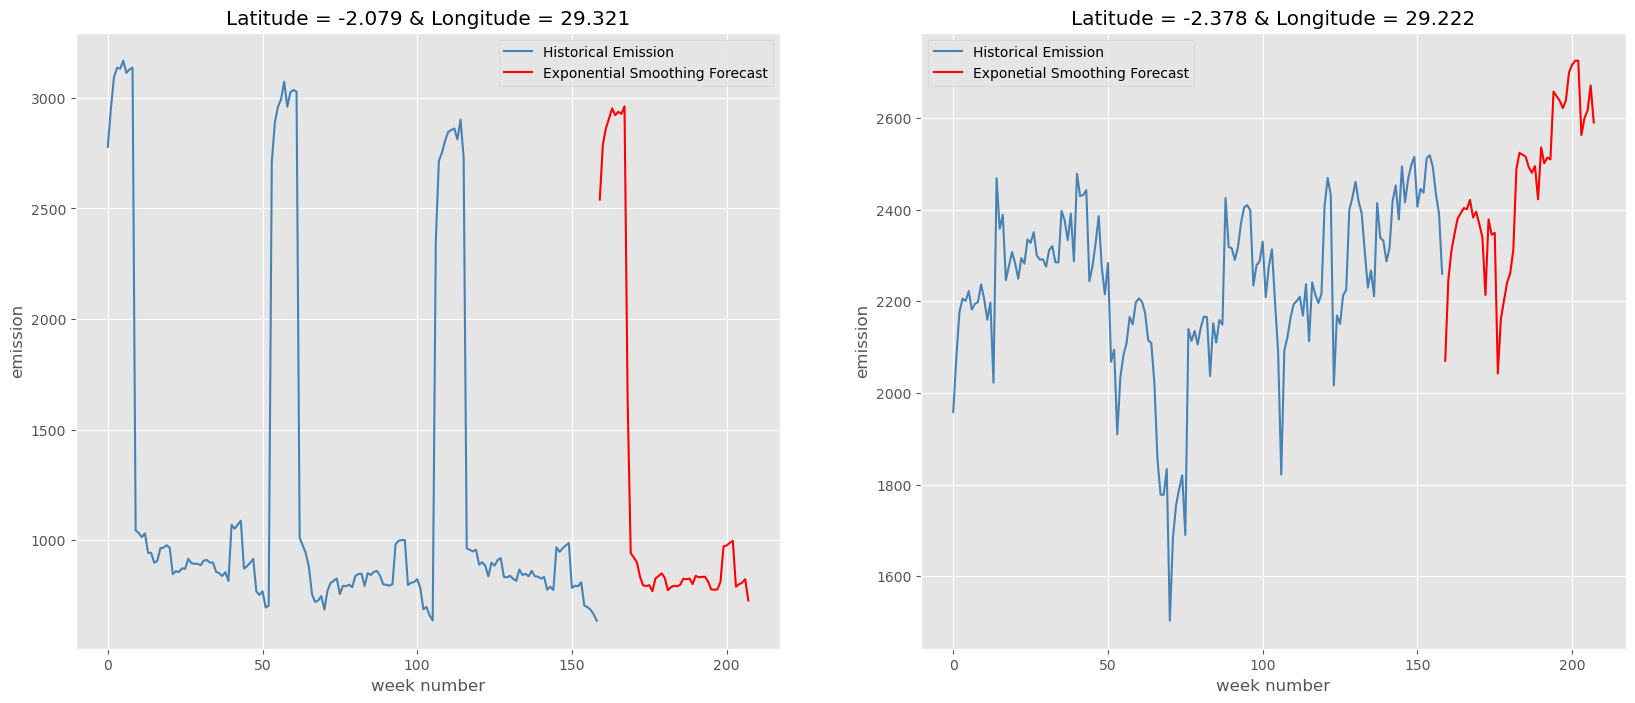

In [21]:
test_outlier = test[np.isin(test['location'], outliers)].copy()
test_outlier['emission'] = np.nan

# each time create one model for only one point

outlier_1 = train[train['location'] == '-2.079_29.321'][['emission']].reset_index(drop = True)
ts_md_1 = ExponentialSmoothing(outlier_1['emission'], seasonal_periods = 53, trend = 'add', seasonal = 'add').fit()
outlier_1_forecast = ts_md_1.forecast(steps = 49)

outlier_2 = train[train['location'] == '-2.378_29.222'][['emission']].reset_index(drop = True)
ts_md_2 = ExponentialSmoothing(outlier_2['emission'], seasonal_periods = 53, trend = 'add', seasonal = 'add').fit()
outlier_2_forecast = ts_md_2.forecast(steps = 49)

fig, axes = plt.subplots(1, 2, figsize = (20, 8))

sns.lineplot(ax = axes[0], x = [i for i in range(0, 159)], y = outlier_1['emission'], color = 'steelblue', label = 'Historical Emission')
sns.lineplot(ax = axes[0], x = [i for i in range(159, 208)], y = outlier_1_forecast, color = 'red', label = 'Exponential Smoothing Forecast')
axes[0].set(xlabel = 'week number', ylabel = 'emission', title = 'Latitude = -2.079 & Longitude = 29.321');

sns.lineplot(ax = axes[1], x = [i for i in range(0, 159)], y = outlier_2['emission'], color = 'steelblue', label = 'Historical Emission')
sns.lineplot(ax = axes[1], x = [i for i in range(159, 208)], y = outlier_2_forecast, color = 'red', label = 'Exponetial Smoothing Forecast')
axes[1].set(xlabel = 'week number', ylabel = 'emission', title = 'Latitude = -2.378 & Longitude = 29.222');

In [ ]:
submission = pd.merge(submission, test_no_outlier, on = 'ID_LAT_LON_YEAR_WEEK', how = 'left')

submission = pd.merge(submission, test_no_outlier, on = 'ID_LAT_LON_YEAR_WEEK', how = 'left')
submission = pd.merge(submission, test_outlier, on = 'ID_LAT_LON_YEAR_WEEK', how = 'left')

submission['emission'] = np.where(submission['emission'].isnull(), submission['emission_y'], submission['emission'])

submission = submission.drop(columns = ['emission_x', 'emission_y'], axis = 1)
submission.head()

# A pipeline for input, modeling, and output

In [10]:
# load data and prepare output csv file

train = pd.read_csv(path+'/dataset/train.csv')
test = pd.read_csv(path+'/dataset/test.csv')
submission = pd.read_csv(path+'/dataset/sample_submission.csv')

# create new features -- simple new feature

train['covid_flag'] = np.where((train['year'] == 2020) & (train['week_no'] >= 11) & (train['week_no'] <= 40), 1, 0)
test['covid_flag'] = 0

train['week_no_sin'] = np.sin(train['week_no']*(2*np.pi/52))
train['week_no_cos'] = np.cos(train['week_no']*(2*np.pi/52))

test['week_no_sin'] = np.sin(test['week_no']*(2*np.pi/52))
test['week_no_cos'] = np.cos(test['week_no']*(2*np.pi/52))


# create a new category as location
train['location'] = [str(train['latitude'][i]) + '_' + str(train['longitude'][i]) for i in range(0, train.shape[0])]
test['location'] = [str(test['latitude'][i]) + '_' + str(test['longitude'][i]) for i in range(0, test.shape[0])]

train['location'] = train['location'].astype('category')
test['location'] = test['location'].astype('category')




In [11]:
# deal with outlier; before run prediction

# first train a lightboost on non-outlier dataset 

outliers = ['-2.079_29.321', '-2.378_29.222']

# remove the outlier grid point only
train_no_outlier = train[~np.isin(train['location'], outliers)].copy()
test_no_outlier = test[~np.isin(test['location'], outliers)].copy() # num of non-outlier points in test dataset: 24353 - 24255

train_outlier = train[np.isin(train['location'], outliers)].copy()
test_outlier = test[np.isin(test['location'], outliers)].copy()


In [ ]:
# prepare for prediction

X = train_no_outlier[['year', 'week_no', 'location', 'covid_flag', 'week_no_sin', 'week_no_cos']].copy()
Y = train_no_outlier['emission']

test_baseline = test_no_outlier[['week_no', 'location', 'covid_flag', 'week_no_sin', 'week_no_cos']].copy()

X = train_outlier[['year', 'week_no', 'location', 'covid_flag', 'week_no_sin', 'week_no_cos']].copy()
Y = train_outlier['emission']

test_baseline = test_outlier[['week_no', 'location', 'covid_flag', 'week_no_sin', 'week_no_cos']].copy()

In [ ]:
# host output

preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0) # take the mean of each model at each k-foler
test_no_outlier = test_no_outlier.reset_index()
test_no_outlier['emission'] = preds_test
test_no_outlier['emission'] = np.where(test_no_outlier['emission'] < 0, 0, test_no_outlier['emission'])
test_no_outlier = test_no_outlier[['ID_LAT_LON_YEAR_WEEK', 'emission']].copy()
test_no_outlier.head()

In [ ]:
# merge two types of prediction

submission = pd.merge(submission, test_no_outlier, on = 'ID_LAT_LON_YEAR_WEEK', how = 'left')

submission = pd.merge(submission, test_no_outlier, on = 'ID_LAT_LON_YEAR_WEEK', how = 'left')
submission = pd.merge(submission, test_outlier, on = 'ID_LAT_LON_YEAR_WEEK', how = 'left')

submission['emission'] = np.where(submission['emission'].isnull(), submission['emission_y'], submission['emission'])

submission = submission.drop(columns = ['emission_x', 'emission_y'], axis = 1)
submission.head()